# Using MOSEK in Google Colab

You can run this notebook in Google Colab (or any other environment that provides ``!pip install``) as is. There is no need to install a license or anything else.

The optimization will be performed on https://solve.mosek.com/.

In [ ]:
# Install MOSEK if not already installed
!pip install mosek

In [2]:
# In this example we use the Fusion API
#    https://docs.mosek.com/latest/pythonfusion/index.html
# One could also use the lower level Optimizer API for Python
#    https://docs.mosek.com/latest/pythonapi/index.html
from mosek.fusion import *
import sys
import numpy as np
np.random.seed(71749373)

# Set up a very simple linear regression problem for demonstration
def mosek_least_squares(m, n, A, b, log):
  M = Model()
  x = M.variable(n)
  t = M.variable()

  # t >= ||Ax-b||_2
  M.constraint(Expr.vstack(t, Expr.sub(Expr.mul(A, x), b)),
               Domain.inQCone())
  
  M.objective(ObjectiveSense.Minimize, t)

  # Use the online demo optimization server
  M.optserverHost("http://solve.mosek.com:30080") 
  M.setLogHandler(sys.stdout if log else None)
  M.solve()

  print("Problem status: {prosta}".format(prosta=M.getProblemStatus()))
  print("residual: {t}".format(t=t.level()[0]))

  if M.getProblemStatus() == ProblemStatus.PrimalAndDualFeasible:
    return x.level()

In [3]:
# Random example
m, n = 20, 15
A = np.random.randn(m, n)
b = np.random.randn(m)

x = mosek_least_squares(m, n, A, b, False)

Problem status: ProblemStatus.PrimalAndDualFeasible
residual: 1.5633248125910382


Problem status: ProblemStatus.PrimalAndDualFeasible
residual: 0.689564246467142
Regression line: 2.902 x + 1.034


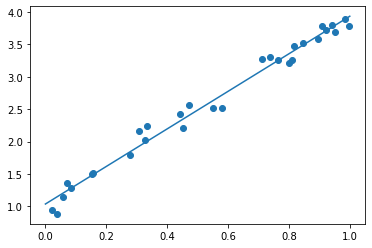

In [4]:
# 2-dimensional example with intercept
m = 30
X = np.random.rand(m)
Y = 3 * X + 1 + 0.5*(np.random.rand(m)-0.5)

a = mosek_least_squares(m, 2, np.vstack((X,np.ones(m))).transpose(), Y, False)

print("Regression line: {0:.3f} x + {1:.3f}".format(a[0], a[1]))
%matplotlib inline
import matplotlib.pyplot as plt
d = np.linspace(0, 1, 2)
plt.scatter(X, Y)
plt.plot(d, a[0] * d + a[1])

# What now?

The demo service at https://solve.mosek.com has size limitations. If you want to use MOSEK on your own grab and install a [trial](https://www.mosek.com/try/) or [academic](https://www.mosek.com/products/academic-licenses/) license and remove the call to ``M.optserverHost`` to optimize locally.

Alternatively, install your own [OptServer](https://github.com/MOSEK/Dockerfiles/tree/master/optserver-demo), install a license there, and redirect to it in the ``M.optserverHost`` call.